# Fitting spectroscopic data with Bagpipes

Fitting spectroscopic data is much more complex than fitting photometry. The approach described below has been designed for VANDELS spectroscopy, and will require experimentation and adaptation to be applied elsewhere.

## Setting up

First we again need the load_data functions from Example 2.

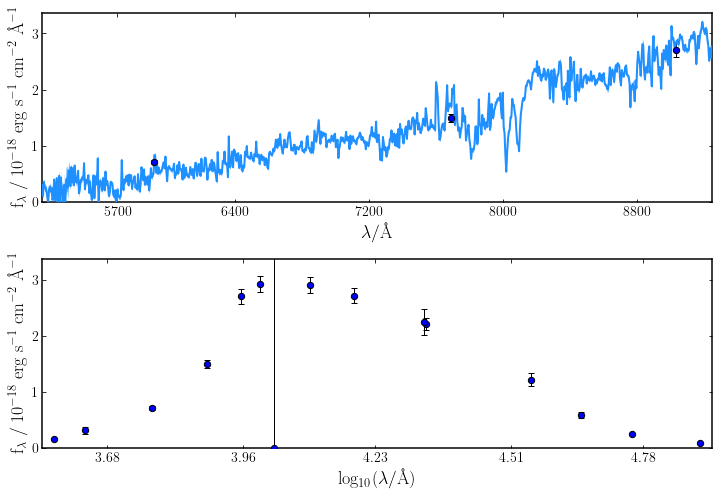

In [1]:
import numpy as np 
import bagpipes as pipes
import os

from astropy.io import fits

def load_goodss(ID):
#     """ Load UltraVISTA photometry from catalogue. """

#     # load up the relevant columns from the catalogue.
#     cat = np.loadtxt("hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1-1photom_cat.txt",
#                      usecols=(10, 13, 16, 19, 25, 28, 31, 34, 37, 40, 43, 46, 49, 52, 55,
#                               11, 14, 17, 20, 26, 29, 32, 35, 38, 41, 44, 47, 50, 53, 56))
    
#     # Find the correct row for the object we want.
#     row = int(ID) - 1

#     # Extract the object we want from the catalogue.
#     fluxes = cat[row, :15]
#     fluxerrs = cat[row, 15:]

#     # Turn these into a 2D array.
#     photometry = np.c_[fluxes, fluxerrs]

#     # blow up the errors associated with any missing fluxes.
#     for i in range(len(photometry)):
#         if (photometry[i, 0] == 0.) or (photometry[i, 1] <= 0):
#             photometry[i,:] = [0., 9.9*10**99.]
            
#     # Enforce a maximum SNR of 20, or 10 in the IRAC channels.
#     for i in range(len(photometry)):
#         if i < 10:
#             max_snr = 20.
            
#         else:
#             max_snr = 10.
        
#         if photometry[i, 0]/photometry[i, 1] > max_snr:
#             photometry[i, 1] = photometry[i, 0]/max_snr

    return np.array([[6.987040e-02, 7.049980e-03],
                     [1.923840e-01, 4.059220e-02],
                     [8.308090e-01, 4.154045e-02],
                     [2.950840e+00, 1.475420e-01],
                     [7.377370e+00, 3.688685e-01],
                     [9.502210e+00, 4.751105e-01],
                     [0.000000e+00, 9.900000e+99],
                     [1.516060e+01, 7.580300e-01],
                     [2.142950e+01, 1.071475e+00],
                     [3.460530e+01, 1.730265e+00],
                     [3.460900e+01, 3.460900e+00],
                     [5.131500e+01, 5.131500e+00],
                     [3.950320e+01, 3.950320e+00],
                     [2.687740e+01, 2.687740e+00],
                     [1.799710e+01, 1.799710e+00]])


def bin(spectrum, binn):
    """ Bins up two or three column spectral data by a specified factor. """

    binn = int(binn)
    nbins = len(spectrum)/binn
    binspec = np.zeros((int(nbins), spectrum.shape[1]))

    for i in range(binspec.shape[0]):
        spec_slice = spectrum[i*binn:(i+1)*binn, :]
        binspec[i, 0] = np.mean(spec_slice[:, 0])
        binspec[i, 1] = np.mean(spec_slice[:, 1])

        if spectrum.shape[1] == 3:
            binspec[i,2] = (1./float(binn)
                            *np.sqrt(np.sum(spec_slice[:, 2]**2)))

    return binspec


def load_vandels_spec(ID):
    """ Loads VANDELS spectroscopic data from file. """

    path = os.path.join(os.sep, 'Users', 'lzq', 'Dropbox', 'qso_cgm', 'test', 'examples', 'VANDELS_CDFS_017433.fits')
    hdulist = fits.open(path)

    spectrum = np.c_[hdulist[1].data["WAVE"][0],
                     hdulist[1].data["FLUX"][0],
                     hdulist[1].data["ERR"][0]]

    mask = (spectrum[:,0] < 9250.) & (spectrum[:,0] > 5250.)

    return bin(spectrum[mask], 2)


def load_both(ID):
    spectrum = load_vandels_spec(ID)
    phot = load_goodss(ID)

    return spectrum, phot


goodss_filt_list = np.loadtxt("filters/goodss_filt_list.txt", dtype="str")
galaxy = pipes.galaxy("017433", load_both, filt_list=goodss_filt_list)

fig = galaxy.plot()

## A fit instructions dictionary for spectroscopy

Let's start off with a model similar to the double-power-law model we fitted in Example 4 except using the variable-slope Charlot & Fall (2001) dust model instead of Calzetti.

In [2]:
dblplaw = {}                        
dblplaw["tau"] = (0., 15.)            
dblplaw["alpha"] = (0.01, 1000.)
dblplaw["beta"] = (0.01, 1000.)
dblplaw["alpha_prior"] = "log_10"
dblplaw["beta_prior"] = "log_10"
dblplaw["massformed"] = (1., 15.)
dblplaw["metallicity"] = (0.1, 2.)
dblplaw["metallicity_prior"] = "log_10"

nebular = {}
nebular["logU"] = -3.

dust = {}
dust["type"] = "CF00"
dust["eta"] = 2.
dust["Av"] = (0., 2.0)
dust["n"] = (0.3, 2.5)
dust["n_prior"] = "Gaussian"
dust["n_prior_mu"] = 0.7
dust["n_prior_sigma"] = 0.3

fit_instructions = {}
fit_instructions["redshift"] = (0.75, 1.25)
fit_instructions["t_bc"] = 0.01
fit_instructions["redshift_prior"] = "Gaussian"
fit_instructions["redshift_prior_mu"] = 0.9
fit_instructions["redshift_prior_sigma"] = 0.05
fit_instructions["dblplaw"] = dblplaw 
fit_instructions["nebular"] = nebular
fit_instructions["dust"] = dust

Now we need to think about a few different issues. Firstly, we need to model the velocity dispersion in the spectrum. Bagpipes does this by convolving the spectroscopic output with a Gaussian kernel in velocity space. We can very the width of this kernel with:

In [3]:
fit_instructions["veldisp"] = (1., 1000.)   #km/s
fit_instructions["veldisp_prior"] = "log_10"

Now we need to think about relative flux calibration. There are several different things to consider here, for example:
 - Aperture mismatch between spectroscopy and photometry
 - Innaccurate relative flux calibration as a function of wavelength in spectroscopic data
 - Underestimated uncertainties in spectroscopic data
 - Template mismatch between the models and data
 
The first step I take in dealing with these issues is to fit a Chebyshev polynomial perturbation to the spectroscopic data to deal with any calibration issues and to match the models. This is added to the model by adding a calibration dictionary to the fit_instructions dictionary:

In [4]:
calib = {}
calib["type"] = "polynomial_bayesian"

calib["0"] = (0.5, 1.5) # Zero order is centred on 1, at which point there is no change to the spectrum.
calib["0_prior"] = "Gaussian"
calib["0_prior_mu"] = 1.0
calib["0_prior_sigma"] = 0.25

calib["1"] = (-0.5, 0.5) # Subsequent orders are centred on zero.
calib["1_prior"] = "Gaussian"
calib["1_prior_mu"] = 0.
calib["1_prior_sigma"] = 0.25

calib["2"] = (-0.5, 0.5)
calib["2_prior"] = "Gaussian"
calib["2_prior_mu"] = 0.
calib["2_prior_sigma"] = 0.25

fit_instructions["calib"] = calib

This introduces three new free parameters into the fit, which is going to slow things down. In order to try to mitigate this I've added another option which uses chi-squared minimisation to find the maximum likelihood polynomial for each spectral model that is compared to the data, instead of full Bayesian fitting of the polynomial.

This doesn't quite treat the uncertainties properly, but in most cases the difference should hopefully be minimial, this hasn't been extensively tested though. You can fit a maximum-likelihood polynomial with the following polynomial dictionary, however we'll continue with the Bayesian approach for now

In [5]:
mlpoly = {}
mlpoly["type"] = "polynomial_max_like"
mlpoly["order"] = 2

Next up is dealing with potentially underestimated errors. The "noise" model component can be used to fit a multiplicative factor to all of the spectroscopic uncertainties as follows:

In [6]:
noise = {}
noise["type"] = "white_scaled"
noise["scaling"] = (1., 10.)
noise["scaling_prior"] = "log_10"
fit_instructions["noise"] = noise

## Fitting the data

It's time to run the sampler. The higher dimensionality of this model means it's going to take longer to sample the parameter space.

In [7]:
fit = pipes.fit(galaxy, fit_instructions, run="spectroscopy")

fit.fit(verbose=False)


Bagpipes: fitting object 017433

 MultiNest Warning: no resume file found, starting from scratch
 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points =  400
 dimensionality =   13
 *****************************************************

Completed in 3624.1 seconds.
 ln(ev)=  -1127.5996635371218      +/-  0.32040215839017921     
 Total Likelihood Evaluations:       439068
 Sampling finished. Exiting MultiNest

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
calib:0                        1.077      1.107      1.134
calib:1                       -0.209     -0.188     -0.164
calib:2                        0.079      0.090      0.100
dblplaw:alpha                  4.946      5.965      7.403
dblplaw:beta                   0.052      0.533     12.019
dblplaw:massformed  

/Users/lzq/anaconda3/envs/astroconda/lib/python3.7/site-packages/bagpipes/models/star_formation_history.py:270: RuntimeWarning: overflow encountered in power
  sfr[mask] = ((t/tau)**alpha + (t/tau)**-beta)**-1


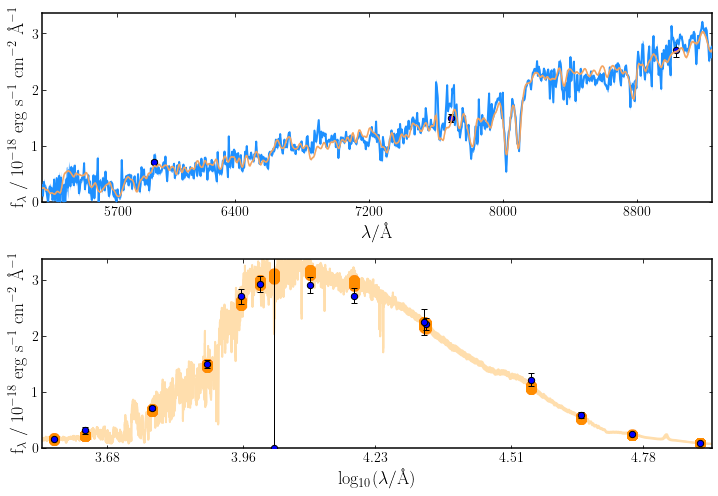

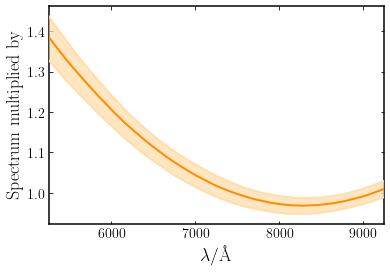

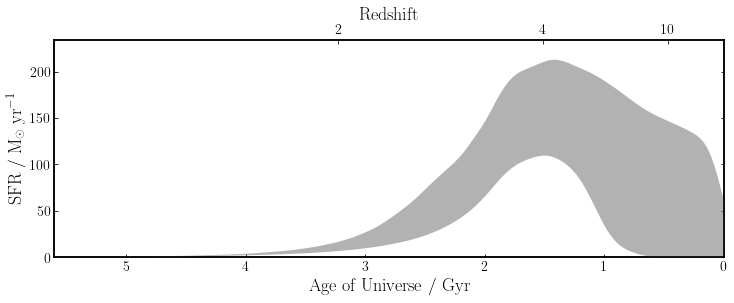

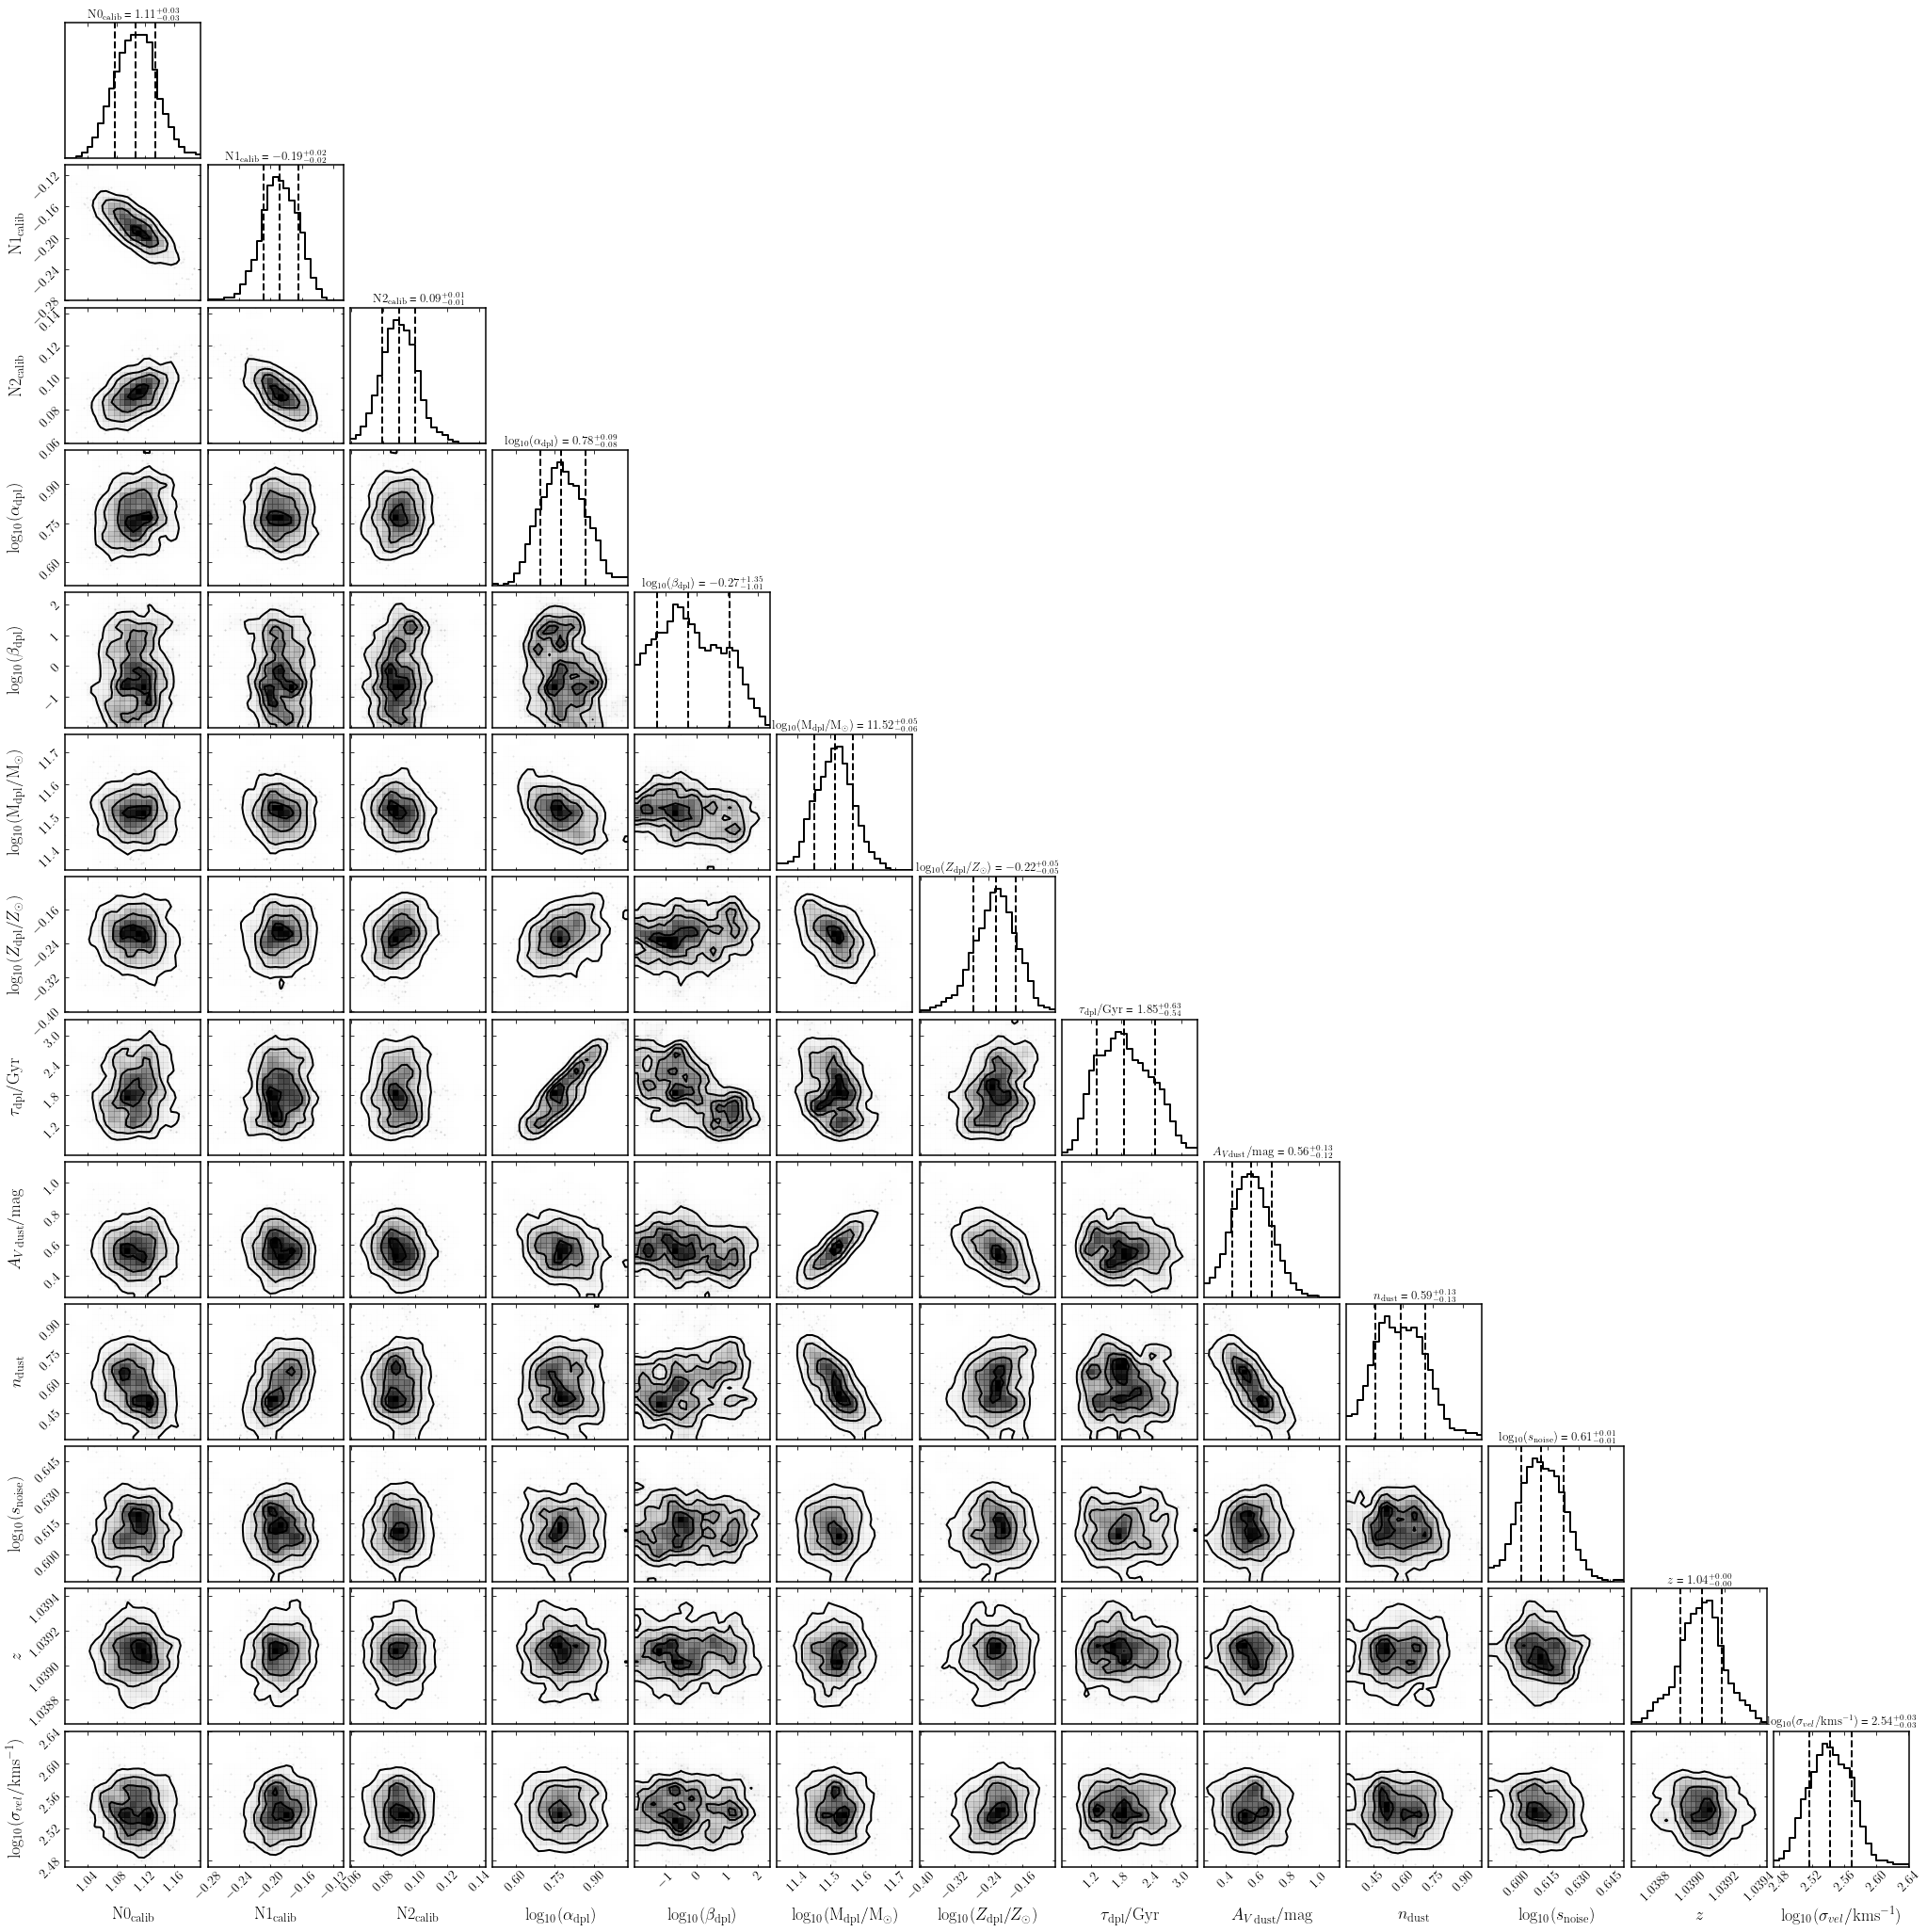

In [8]:
fig = fit.plot_spectrum_posterior(save=False, show=True)
fig = fit.plot_calibration(save=False, show=True)
fig = fit.plot_sfh_posterior(save=False, show=True)
fig = fit.plot_corner(save=False, show=True)

Fitting spectroscopy is far more sophisticated and challenging than photometry. Bagpipes provides several tools for doing this, but significant consideration and testing will be necessary to understand what is necessary for a particular use case. More details can be found in [Carnall et al. (2019b)](https://arxiv.org/abs/1903.11082). I am happy to be consulted by individuals who are considering using Bagpipes for these kinds of projects.